# <font color='blue'>Data Science Academy - <a href="https://www.datascienceacademy.com.br">www.datascienceacademy.com.br</a></font>

## Bonus do Curso Microsoft Power BI Para Data Science

O objetivo deste notebook é dar a você uma visão geral sobre um dos modelos de Redes Neurais Artificiais mais utilizado em tarefas de Visão Computacional, o modelo de Redes Neurais Convolucionais.

Para adquirir conhecimento técnico sólido e especializado em Redes Neurais Artificiais, Visão Computacional e outros temas relacionados à Inteligência Artificial, confira nosso programa completo: <a href="https://www.datascienceacademy.com.br/pages/formacao-inteligencia-artificial">Formação Inteligência Artificial</a>.

# Microsoft Cognitive Toolkit (CNTK)

# Rede Neural Convolucional

Vamos construir e treinar um modelo de rede neural convolucional usando o dataset MNIST. 

## Introdução

Uma Rede Neural Convolucional (CNN ou ConvNet) é um tipo de rede neural artificial constituída por neurônios que têm pesos e biases, muito semelhante ao Multilayer Perceptron (MLP). As CNNs aproveitam a natureza espacial dos dados. Na natureza, percebemos objetos diferentes por suas formas, tamanho e cores. Por exemplo, os objetos em uma cena natural são tipicamente bordas, cantos/vértices, shapes, textura, etc. Essas primitivas são frequentemente identificadas usando diferentes detectores (por exemplo, detecção de borda, detector de cor) ou combinação de detectores interagindo Para facilitar a interpretação de imagem (classificação de objeto, região de detecção de interesse, descrição de cena, etc.) em tarefas relacionadas à visão computacional. Estes detectores são também conhecidos como filtros. Convolução é um operador matemático que recebe uma imagem e um filtro como entrada e produz uma saída filtrada (representando egdges, cantos ou cores na imagem de entrada). Historicamente, esses filtros são um conjunto de pesos que eram muitas vezes artesanais ou modelados com funções matemáticas. As saídas de filtro são mapeadas através de funções de ativação não-lineares imitando as células cerebrais humanas chamadas neurônios.

As redes convolucionais fornecem um mecanismos para aprender esses filtros a partir dos dados diretamente em vez de modelos matemáticos explícitos e são considerados superiores (em tarefas do mundo real) em comparação com filtros historicamente criados. Com redes convolucionais, o foco está em aprender os pesos de filtros em vez de aprender pares totalmente conectados (entre entradas e saídas). Desta forma, o número de pesos a aprender é reduzido quando comparado com as redes MLP tradicionais. Em uma rede convolucional, um modelo aprende vários filtros que variam de poucos dígitos simples a poucos milhares dependendo da complexidade da rede.

Muitos dos primitivos da CNN mostraram ter componentes conceitualmente paralelos no cérebro [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex). O grupo de neurônios no córtex visual emite respostas quando estimulado. Esta região é conhecida como campo receptivo (RF). Equivalentemente, em convolução, a região de entrada correspondente às dimensões do filtro e pode ser considerada como o campo receptivo. Populares CNNs ou ConvNets profundas (como [AlexNet](https://en.wikipedia.org/wiki/AlexNet), [VGG](https://arxiv.org/abs/1409.1556), [Inception](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf), [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf)) que são usados para [computer vision](https://en.wikipedia.org/wiki/Computer_vision) têm muitas dessas primitivas (inspiradas na biologia).

In [1]:
from IPython.display import display, Image

In [2]:
# Figure 1
Image(url= "mnist_originals.png", width=200, height=200)

**Objetivo**:
Nosso objetivo é treinar um classificador que identifique os dígitos no conjunto de dados MNIST.

**Abordagem**:

Os mesmos 5 estágios que usamos anteriormente são aplicáveis: leitura de dados, pré-processamento de dados, criação de um modelo, aprendizado dos parâmetros do modelo e avaliação do modelo (teste/previsão).

Vamos experimentar dois modelos com diferentes componentes.

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C

%matplotlib inline

In [4]:
# Definindo o dispositivo de processamento
C.device.try_set_default_device(C.device.gpu(0))

True

## Leitura dos Dados

Estamos usando os dados MNIST. O conjunto de dados tem 60.000 imagens de treinamento e 10.000 imagens de teste, com cada imagem sendo 28 x 28 pixels. Assim, o número de recursos é igual a 784 (= 28 x 28 pixels), 1 por pixel. A variável `num_output_classes` é definida como 10 correspondente ao número de dígitos (0-9) no conjunto de dados.

Nos modelos anteriores, nós sempre convertemos a imagem de entrada em um vetor. Com as redes convolucionais, não convertemos a imagem desta maneira.

![MNIST-flat](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

** Dimensões de entrada **:

Em redes convolucionais para imagens, os dados de entrada são muitas vezes moldados como uma matriz 3D (número de canais, largura da imagem, altura), que preserva a relação espacial entre os pixels. Na figura acima, a imagem MNIST é um único canal (tons de cinza) de dados, portanto, a dimensão de entrada é especificada como uma (1, largura da imagem, altura da imagem) tupla.

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

Imagens de cor de cena natural são frequentemente apresentadas como canais de cor Vermelho-Verde-Azul (RGB). A dimensão de entrada dessas imagens é especificada como uma tupla (3, largura da imagem, altura da imagem). Se houver dados de entrada RGB como uma varredura volumétrica com largura de volume, altura de volume e profundidade de volume representando os 3 eixos, o formato de dados de entrada será especificado por uma tupla de 4 valores (3, largura de volume, altura de volume, profundidade de volume). Desta forma, o CNTK permite a especificação de imagens de entrada em espaço arbitrário de dimensão superior.

In [5]:
# Random seed
np.random.seed(0)

# Dimensões dos dados
input_dim_model = (1, 28, 28)    # as imagens são 28 x 28 com 1 canal de cor (gray)
input_dim = 28*28                # usado para tratar o input como vetor 
num_output_classes = 10

** Formato de Dados ** Os dados são armazenados em nossa máquina local no formato CNTK CTF. O formato CTF é um formato de texto simples que contém um conjunto de amostras com cada amostra contendo um conjunto de campos nomeados e seus dados. Para os nossos dados MNIST, cada amostra contém 2 campos: rótulos e recurso, formatados como:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 255 0 123 ... 
                                                  (784 integers each representing a pixel gray level)
    
Vamos usar os pixels de imagem correspondentes ao fluxo inteiro chamado "features". Definimos uma função `create_reader` para ler os dados de treinamento e teste usando o [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html#cntk.io.CTFDeserializer). . 

Os rótulos são One-Hot Encoded [1-hot](https://en.wikipedia.org/wiki/One-hot) (o rótulo que representa a classe de saída de 3 torna-se "0001000000" uma vez que temos 10 classes para os 10 dígitos possíveis), onde o primeiro índice corresponde ao dígito "0" e o último corresponde ao dígito "9".

![mnist-label](https://www.cntk.ai/jup/cntk103a_onehot.png)

In [6]:
# Função para leitura dos dados
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [7]:
# Assegure que os dados de treinamento e teste estejam disponíveis.
data_found = False 
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Por favor, execute o notebook CNTK01 para fazer o download do dataset")
    
print("O diretório dos dados é {0}".format(data_dir))

O diretório dos dados é data/MNIST


<a id='#Criação do Modelo'></a>
## Criação do Modelo CNN

CNN é uma rede feedforward composta de um monte de camadas de tal forma que a saída de uma camada torna-se a entrada para a próxima camada (semelhante ao MLP). Em MLP, todos os pares possíveis de pixels de entrada são conectados aos nós de saída com cada par tendo um peso, conduzindo assim a uma explosão combinatória de parâmetros a serem aprendidos e também aumentando a possibilidade de overfitting. As camadas de convolução aproveitam a disposição espacial dos pixels e aprendem vários filtros que reduzem significativamente a quantidade de parâmetros na rede. O tamanho do filtro é um parâmetro da camada de convolução.

Nesta seção, apresentamos os fundamentos das operações de convolução. Nós mostramos as ilustrações no contexto de imagens RGB (3 canais), embora os dados MNIST que estamos usando neste tutorial é uma imagem em escala de cinza (canal único).

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

### Convolution Layer

Uma camada de convolução é um conjunto de filtros. Cada filtro é definido por uma matriz de peso (** W **) e bias ($ b $).

![input-filter](https://www.cntk.ai/jup/cntk103d_filterset.png)

Estes filtros são varridos através da imagem que realiza o produto do ponto entre os pesos e o valor de entrada correspondente ($\vec{x}^T$). O valor de bias é adicionado à saída do produto de ponto e a soma resultante é opcionalmente mapeada através de uma função de ativação. Esse processo é ilustrado na seguinte animação.

In [8]:
Image(url="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif", width= 300)

As camadas de convolução incorporam as seguintes características-chave:

  - Em vez de estar totalmente conectado a todos os pares de nós de entrada e saída, cada nó de convolução é ** conectado localmente ** a um subconjunto de nós de entrada localizados em uma região de entrada menor, também chamada de campo receptivo (RF). A figura acima ilustra pequenas regiões 3 x 3 na imagem como a região RF. No caso de uma imagem RGB, haveria três dessas 3 x 3 regiões, uma de cada um dos 3 canais de cor.
   
   
   - Em vez de ter um único conjunto de pesos (como em uma camada Densa), camadas convolucionais têm vários conjuntos (mostrado na figura com várias cores), chamado ** filtros **. Cada filtro detecta características dentro de cada RF possível na imagem de entrada. A saída da convolução é um conjunto de sub-camadas `n` (mostradas na animação abaixo) onde ` n` é o número de filtros (consulte a figura acima).
   
     
   - Dentro de uma subcamada, em vez de cada nó ter seu próprio conjunto de pesos, um único conjunto de ** pesos compartilhados ** são usados por todos os nós nessa subcamada. Isso reduz o número de parâmetros a serem aprendidos. Isso também abre a porta para vários aspectos da aprendizagem profunda que permitiu a construção de soluções muito práticas:
     -- Manuseio de imagens maiores (digamos 512 x 512)
     -- Tentando maiores tamanhos de filtro (correspondente a um RF maior) como 11 x 11
     -- Aprender mais filtros (digamos 128)
     -- Explorar arquiteturas mais profundas (mais de 100 camadas)
     -- Alcançar a invariância de tradução (a capacidade de reconhecer um recurso independentemente de onde eles aparecem na imagem).

### Strides e Padding

** Como os filtros são posicionados? ** Em geral, os filtros são dispostos em telhas sobrepostas, da esquerda para a direita e de cima para baixo. Cada camada de convolução tem um parâmetro para especificar a `filter_shape`, especificando a largura e a altura do filtro no caso das imagens de cena mais naturais. Há um parâmetro (`strides`) que controla a distância até a etapa para a direita ao mover os filtros através de vários RF's em uma linha, e até que ponto para descer quando se move para a próxima linha. O parâmetro booleano `pad` controla se a entrada deve ser preenchida em torno das bordas para permitir um mosaico completo dos RFs perto das bordas.

A animação acima mostra os resultados com um `filter_shape` = (3, 3),` strides` = (2, 2) e `pad` = False. As duas animações abaixo mostram os resultados quando `pad` é definido como True. Primeiro, com um passo de 2 e segundo tendo um passo de 1.

Nota: a forma da saída é diferente entre as duas configurações. Muitas vezes a sua decisão de pad e os valores de stride é baseada na forma da camada de saída necessária.

In [9]:
# Plot images com strides de 2 e 1 e padding habilitado
images = [("https://www.cntk.ai/jup/cntk103d_padding_strides.gif" , 'Stride = 2'),
          ("https://www.cntk.ai/jup/cntk103d_same_padding_no_strides.gif", 'Stride = 1')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

Stride = 2


Stride = 1


## Construindo o Modelo CNN

Primeiro definimos dois contêineres. Um para a imagem MNIST de entrada e o segundo sendo os rótulos correspondentes aos 10 dígitos. Ao ler os dados, o leitor mapeia automaticamente os 784 pixels por imagem para uma forma definida pela tupla `input_dim_model` (neste exemplo é definido como (1, 28, 28)).

In [10]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

O primeiro modelo que construímos é uma simples rede de convolução. Aqui temos duas camadas convolucionais. Uma vez que, a nossa tarefa é detectar os 10 dígitos na base de dados MNIST, a saída da rede deve ser um vetor de comprimento 10, 1 elemento correspondente a cada dígito. Isto é conseguido projetando a saída da última camada convolucional usando uma camada densa com a saída sendo `num_output_classes`. Já vimos isso antes com Regressão Logística e MLP onde os recursos foram mapeados para o número de classes na camada final. Além disso, note que, uma vez que usaremos o `softmax` com a função de perda `cross entropy` durante o treinamento (ver algumas células abaixo), a camada densa final não tem nenhuma função de ativação associada a ele.

A figura a seguir ilustra o modelo que vamos construir. Observe que os parâmetros no modelo abaixo devem ser experimentados. Estes são frequentemente chamados de hiperparâmetros de rede. Aumentar a forma do filtro leva a um aumento no número de parâmetros do modelo, aumenta o tempo de computação e ajuda o modelo a se ajustar melhor aos dados. No entanto, corre-se o risco de [overfitting](https://en.wikipedia.org/wiki/Overfitting). Normalmente, o número de filtros nas camadas mais profundas é maior do que o número de filtros nas camadas anteriores. Escolhemos 8 e 16 como número de filtros para a primeira e segunda camadas, respectivamente. Estes hiperparâmetros devem ser experimentados durante a construção do modelo.

![conv-only](https://www.cntk.ai/jup/cntk103d_convonly2.png)

** Compreendendo os parâmetros **:


Nosso modelo tem duas camadas de convolução, cada uma com peso e bias. Isso adiciona até 4 tensores de parâmetro. Adicionalmente, a camada densa tem tensores de peso e de bias. Assim, os tensores de 6 parâmetros.

Vamos agora contar o número de parâmetros:
- * Primeira camada de convolução *: Existem 8 filtros cada um de tamanho (1 x 5 x 5) onde 1 é o número de canais na imagem de entrada. Isto adiciona até 200 valores na matriz de peso e 8 valores de bias.


- * Segunda camada de convolução *: Existem 16 filtros cada um de tamanho (8 x 5 x 5) onde 8 é o número de canais na entrada para a segunda camada (= saída da primeira camada). Isto adiciona até 3200 valores na matriz de peso e 16 valores de bias.


- * Última camada densa *: Existem 16 x 7 x 7 valores de entrada e produz 10 valores de saída correspondentes aos 10 dígitos no conjunto de dados MNIST. Isto corresponde a (16 x 7 x 7) x 10 valores de peso e 10 valores de bias.

Adicionando estes acima dá os 11274 parâmetros no modelo.

In [11]:
# Criação do modelo
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape = (5,5), 
                                       num_filters = 8, 
                                       strides = (2,2), 
                                       pad = True, name = 'first_conv')(h)
            h = C.layers.Convolution2D(filter_shape = (5,5), 
                                       num_filters = 16, 
                                       strides = (2,2), 
                                       pad = True, name = 'second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation = None, name = 'classify')(h)
            return r

Vamos criar uma instância do modelo e inspecionar os diferentes componentes do modelo. `Z` será usado para representar a saída de uma rede. Neste modelo, usamos a função de ativação `relu`. Nota: usar o `C.layers.default_options` é uma forma elegante de escrever modelos concisos. Isso é fundamental para minimizar erros de modelagem, economizando tempo de depuração precioso.

In [12]:
# Cria o modelo
z = create_model(x)

# Imprimir as formas / parâmetros de saída dos diferentes componentes
print("Shape do Output da primeira camada de convolução:", z.first_conv.shape)
print("Valor do Bias Bias da última camada densa:", z.classify.b.value)

Shape do Output da primeira camada de convolução: (8, 14, 14)
Valor do Bias Bias da última camada densa: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Entender o número de parâmetros do modelo a ser estimado é fundamental para a aprendizagem profunda, pois há uma dependência direta da quantidade de dados que se precisa ter. Você precisa de mais dados para um modelo que tenha maior número de parâmetros para evitar overfitting. Em outras palavras, com uma quantidade fixa de dados, é preciso restringir o número de parâmetros. Não há nenhuma regra de ouro entre a quantidade de dados que se precisa para um modelo.

In [13]:
# Número de parâmetros na rede
C.logging.log_number_of_parameters(z)

Training 11274 parameters in 6 parameter tensors.


## Treinamento

Nós usamos a entropia cruzada entre o rótulo (label) e a probabilidade prevista pela rede.

In [14]:
# Criando uma função com as métricas da rede
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

Em seguida, precisamos de uma função auxiliar para executar o treinamento do modelo. Primeiro, vamos criar funções auxiliares adicionais que serão necessárias para visualizar diferentes funções associadas ao treinamento.

In [15]:
# Definir uma função de utilidade para calcular a soma da média.
# Uma implementação mais eficiente é possível com a função np.cumsum ()
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Define um utilitário que imprime o progresso do treinamento
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Configurando o Treinamento


In [16]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instanciar a função do modelo; X é a variável de entrada (característica)
    # Nós dimensionaremos os pixels da imagem de entrada dentro da faixa 0-1 dividindo todo o valor de entrada por 255.
    model = model_func(x/255)
    
    # Instanciar a função de perda e erro
    loss, label_error = create_criterion_function(model, y)
    
    # Instanciar o objeto do instrutor para conduzir o treinamento do modelo
    learning_rate = 0.2
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Inicializar os parâmetros para o treinador
    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Mapear os fluxos de dados para a entrada e os rótulos.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment abaixo para logging mais detalhado
    training_progress_output_freq = 500
     
    # Timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Ler um mini-lote do arquivo de dados de treinamento
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("O Treinamento levou {:.1f} sec".format(time.time() - start))
    
    # Dados de Teste
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Dados de teste no modelo treinado
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # Estamos carregando dados de teste em lotes especificados por test_minibatch_size
        # Cada ponto de dados no minibatch é uma imagem do MNIST de 784 posições
        # com um pixel por dimensão que vamos codificar / decodificar com o
        # modelo treinado.
        data = test_reader.next_minibatch(test_minibatch_size, input_map = test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Média dos erros de avaliação de todos os testes minibatches
    print("Erro médio em Teste: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

<a id='#Executando o treinamento'></a>
### Treinando e Avaliando o Modelo

Agora estamos prontos para treinar nossa rede neural convolucional.

In [17]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.2999, Error: 85.94%
Minibatch: 500, Loss: 0.1371, Error: 4.69%
Minibatch: 1000, Loss: 0.0709, Error: 1.56%
Minibatch: 1500, Loss: 0.0640, Error: 3.12%
Minibatch: 2000, Loss: 0.0098, Error: 0.00%
Minibatch: 2500, Loss: 0.0324, Error: 1.56%
Minibatch: 3000, Loss: 0.0656, Error: 3.12%
Minibatch: 3500, Loss: 0.1509, Error: 4.69%
Minibatch: 4000, Loss: 0.0083, Error: 0.00%
Minibatch: 4500, Loss: 0.0417, Error: 3.12%
Minibatch: 5000, Loss: 0.0135, Error: 0.00%
Minibatch: 5500, Loss: 0.0178, Error: 0.00%
Minibatch: 6000, Loss: 0.0112, Error: 0.00%
Minibatch: 6500, Loss: 0.0213, Error: 1.56%
Minibatch: 7000, Loss: 0.0613, Error: 4.69%
Minibatch: 7500, Loss: 0.0127, Error: 0.00%
Minibatch: 8000, Loss: 0.0037, Error: 0.00%
Minibatch: 8500, Loss: 0.0148, Error: 0.00%
Minibatch: 9000, Loss: 0.0172, Error: 0.00%
O Treinamento levou 8.0 sec
Erro médio em Teste: 1.30%


Observe que o erro médio de teste é muito comparável ao nosso erro de treinamento, indicando que nosso modelo tem um bom erro "fora da amostra", isto é, generaliza bem. Isto implica que o nosso modelo pode lidar de forma muito eficaz com observações anteriormente não vistas. Isso é fundamental para evitar [overfitting](https://en.wikipedia.org/wiki/Overfitting).

Vamos verificar qual é o valor de alguns dos parâmetros de rede. Verificaremos o valor de bias da camada densa de saída. Anteriormente, era tudo 0. Agora você vê que há valores diferentes de zero, indicando que os parâmetros de um modelo foram atualizados durante o treinamento.

In [18]:
print("Valor do Bias na última camada densa:", z.classify.b.value)

Valor do Bias na última camada densa: [-0.00159041  0.01341395 -0.02127604 -0.25837696  0.05727205 -0.05524273
  0.01631765  0.01225744  0.26576892 -0.02867727]


## Avaliação / Previsão
Até agora estamos lidando com medidas agregadas de erro. Vamos agora obter as probabilidades associadas a pontos de dados individuais. Para cada observação, a função `eval` retorna a distribuição de probabilidade em todas as classes. O classificador é treinado para reconhecer dígitos, portanto, tem 10 classes. Primeiro vamos direcionar a saída de rede através de uma função `softmax`. Isso mapeia as ativações agregadas através da rede para probabilidades entre as 10 classes.

In [19]:
out = C.softmax(z)

In [20]:
# Lendo os dados para avaliação
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# Reshape das imagens para: M x 1 x 28 x 28 para ser compatível com o modelo
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [21]:
# Encontre o índice com o valor máximo tanto para o previsto como para observado.
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [22]:
print("Label    :", gtlabel[:25])
print("Previsto:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Previsto: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


Image Label:  1


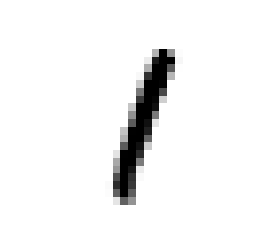

In [23]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

## Pooling Layer

Muitas vezes, é necessário controlar o número de parâmetros, especialmente em redes profundas. Para cada camada de saída da camada de convolução (cada camada, corresponde à saída de um filtro), pode-se ter uma camada de agrupamento (Pooling). As camadas de agrupamento são tipicamente introduzidas para:
- Reduzir a dimensionalidade da camada anterior (acelerando a rede),
- Torna o modelo mais tolerante a alterações no local do objeto na imagem. Por exemplo, mesmo quando um dígito é deslocado para um lado da imagem em vez de estar no meio.

É comum inserir periodicamente uma camada de agrupamento entre as camadas Convolucionais sucessivas em uma arquitetura ConvNet. Sua função é reduzir progressivamente o tamanho espacial da representação para reduzir a quantidade de parâmetros e de computação na rede e, portanto, também para controlar o overfitting. A Camada de Agrupamento opera independentemente em cada fatia de profundidade da entrada e redimensiona-a espacialmente, usando a operação MAX. A forma mais comum é uma camada de pooling com filtros de tamanho 2x2 aplicado com um stride de 2 downsamples cada fatia de profundidade na entrada por 2 ao longo de largura e altura, descartando 75% das ativações. Cada operação MAX, neste caso, seria tomar um máximo de 4 números (pequena região 2x2 em alguma fatia de profundidade). A dimensão da profundidade permanece inalterada.

Vale ressaltar que existem apenas duas variações comumente observadas na camada de Max Pooling encontradas na prática: Uma camada de agrupamento com F = 3, S = 2 (também chamada de pool de sobreposição) e mais comumente F = 2, S = 2. Agrupando tamanhos com campos receptivos maiores pode destruir a rede e travar a máquina.

O cálculo em um nó de pooling é muito mais simples do que um nó de feedforward normal. Ele não tem peso, bias ou função de ativação. Ele usa uma função de agregação simples (como max ou average) para calcular sua saída. A função mais comumente usada é "max" - um nó de pooling máximo simplesmente fornece o máximo dos valores de entrada correspondentes à posição do filtro da entrada. A figura abaixo mostra os valores de entrada em uma região 4 x 4. A tamanho máximo da janela de agrupamento é 2 x 2 e começa a partir do canto superior esquerdo. O valor máximo dentro da janela torna-se a saída da região. Cada vez que o modelo é deslocado pela quantidade especificada pelo parâmetro stride (como mostrado na figura abaixo) e a operação de pooling máximo é repetida.
![maxppool](https://cntk.ai/jup/201/MaxPooling.png)

Outra alternativa é o pooling médio, que emite esse valor médio em vez do valor máximo. As duas opções diferentes estão resumidas na animação abaixo.

In [24]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/c103d_max_pooling.gif" , 'Max pooling'),
          ("https://www.cntk.ai/jup/c103d_average_pooling.gif", 'Average pooling')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

Max pooling


Average pooling


# Rede Convolucional Típica

![mnist-conv-mp](http://www.cntk.ai/jup/conv103d_mnist-conv-mp.png)

Uma CNN típica contém um conjunto de camadas alternadas de convolução e agrupamento (Pooling) seguido por uma camada de saída densa para a classificação. Você encontrará variantes desta estrutura em muitas redes profundas clássicas (VGG, AlexNet etc.). Isto está em contraste com a rede MLP que usamos anteriormente, que consistia em 2 camadas densas seguidas por uma camada de saída densa.

As ilustrações são apresentadas no contexto de imagens bidimensionais (2D), mas o conceito e os componentes CNTK podem operar em qualquer dado dimensional. O esquema acima mostra 2 camadas de convolução e 2 camadas de agrupamento máximo. Uma estratégia típica é aumentar o número de filtros nas camadas mais profundas, reduzindo o tamanho espacial de cada camada intermediária. Camadas intermediárias.

## Criando a Rede com MaxPooling

As redes convolucionais típicas possuem camadas de convolução e de max pooling. O modelo anterior tinha apenas camada de convolução. Nesta seção, você criará um modelo com a seguinte arquitetura.
![conv-only](https://www.cntk.ai/jup/cntk103d_conv_max2.png)

Usaremos a função CNTK [MaxPooling](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.MaxPooling) para atingir nosso objetivo. Vamos editar a função `create_model` e adicionar a operação de MaxPooling. 

In [25]:
# Construindo o modelo
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape = (5,5), 
                                       num_filters = 8, 
                                       strides = (1,1), 
                                       pad = True, name = "first_conv")(h)
            h = C.layers.MaxPooling(filter_shape = (2,2), 
                                    strides = (2,2), name = "first_max")(h)
            h = C.layers.Convolution2D(filter_shape = (5,5), 
                                       num_filters = 16, 
                                       strides = (1,1), 
                                       pad = True, name = "second_conv")(h)
            h = C.layers.MaxPooling(filter_shape = (3,3), 
                                    strides = (3,3), name = "second_max")(h)
            r = C.layers.Dense(num_output_classes, activation = None, name = "classify")(h)
            return r
        
do_train_test()

Minibatch: 0, Loss: 2.3058, Error: 92.19%
Minibatch: 500, Loss: 0.0524, Error: 0.00%
Minibatch: 1000, Loss: 0.0626, Error: 1.56%
Minibatch: 1500, Loss: 0.0211, Error: 0.00%
Minibatch: 2000, Loss: 0.0215, Error: 0.00%
Minibatch: 2500, Loss: 0.0204, Error: 1.56%
Minibatch: 3000, Loss: 0.1623, Error: 4.69%
Minibatch: 3500, Loss: 0.1124, Error: 4.69%
Minibatch: 4000, Loss: 0.0150, Error: 0.00%
Minibatch: 4500, Loss: 0.0294, Error: 1.56%
Minibatch: 5000, Loss: 0.0362, Error: 1.56%
Minibatch: 5500, Loss: 0.0238, Error: 1.56%
Minibatch: 6000, Loss: 0.0115, Error: 0.00%
Minibatch: 6500, Loss: 0.0125, Error: 0.00%
Minibatch: 7000, Loss: 0.0349, Error: 1.56%
Minibatch: 7500, Loss: 0.0172, Error: 1.56%
Minibatch: 8000, Loss: 0.0055, Error: 0.00%
Minibatch: 8500, Loss: 0.0018, Error: 0.00%
Minibatch: 9000, Loss: 0.0023, Error: 0.00%
O Treinamento levou 8.1 sec
Erro médio em Teste: 1.14%


## Fim